In [330]:
"""customize the figure"""
import matplotlib

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick.major', size=8)
matplotlib.rc('xtick.minor', size=4)
matplotlib.rc('ytick.major', size=8)
matplotlib.rc('ytick.minor', size=4)

In [331]:
#from glob import glob
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lxml import etree

%matplotlib inline
##to create table

In [332]:
def simple_smoothing(data,n):
    if np.isnan(np.sum(data)):
        starting_nans = data[np.isnan(data)]
        data_no_nan = data[len(starting_nans):]
        
        smoothed = simple_smoothing(data_no_nan,n)
        return np.append(starting_nans,smoothed)
    
    else:
        cum_sum = np.cumsum(data,dtype=float)
        cum_sum[n:] = cum_sum[n:] - cum_sum[:-n]
        
        nan_array = np.full(n-1,np.nan)
        smoothed = cum_sum[n-1:]/n
        return np.append(nan_array,smoothed)
    

In [333]:
def parse_vr(filename):
    """Returns the Primary unit/divisor, Secondary unit/divisor, sampling rate and recording duration. 
    Returned as a dictionary with keys "primary", "secondary", "sampling", and "duration". 
    Primary and Secondary values are contained in dictionaries with keys "unit" and "divisor"
    """

    tree = etree.parse(filename)
    #Returns elements with associated "Primary" and "Secondary
    primary = tree.xpath('.//Name[text()="Primary"]')
    secondary = tree.xpath('.//Name[text()="Secondary"]')
    #Gets the parent of these elements
    try:
        parent = (primary[0].getparent(), secondary[0].getparent())
    #in case people don't use capital letters for Primary and Secondary labels in PrairieView
    except IndexError:
        primary = tree.xpath('.//Name[text()="primary"]')
        secondary = tree.xpath('.//Name[text()="secondary"]')
        parent = (primary[0].getparent(), secondary[0].getparent())
    #Finds the unit element within parent
    unit = (parent[0].find('.//UnitName'), parent[1].find('.//UnitName'))
    #Finds the divisor element within parent
    divisor = (parent[0].find('.//Divisor'), parent[1].find('.//Divisor'))

    #dictionaries with primary and secondary values
    primary_val = {'unit': unit[0].text, 'divisor': float(divisor[0].text)}
    secondary_val = {'unit': unit[1].text, 'divisor': float(divisor[1].text)}
    #gets sampling rate
    sampling_val = int((tree.find('.//Rate')).text)
    #gets recording time, converts to sec
    duration_val = (int((tree.find('.//AcquisitionTime')).text))/1000

    #finds the voltage recording csv file name
    datafile = (tree.find('.//DataFile')).text
    #finds the linescan profile file name (if doesn't exist, will be None)
    ls_file = (tree.find('.//AssociatedLinescanProfileFile')).text

    #If ls_file is none this could mean that there is no linescan associate with that voltage recording file or that
    #the file passed to parse_vr is actually a LineScan data file and therefore should be passed to ls_file.
    #In that scenario there is no voltage recording data file, so vo_file is None
    if ls_file is None:
        if "LineScan" in datafile:
            ls_file = datafile
            vo_file = None
        elif "LineScan" not in datafile:
            vo_file = datafile
    else:
        vo_file = datafile

    return {'primary': primary_val, 'secondary': secondary_val, 'sampling': sampling_val, 'duration': duration_val,
            'linescan file': ls_file, 'voltage recording file': vo_file}


In [334]:
def import_vr_csv(filename, primary_div=1, secondary_div=1):
    """Reads voltage recording .csv file into a pandas dataframe. Will convert Primary and Secondary channels
    to appropriate values if those channels are in the file. Returns a dataframe
    """
    #loads csv file into pandas dataframe
    df = pd.read_csv(filename, skipinitialspace=True)
    #some files have a unit (ms) associate with Time, so just making the Time column name uniform
    df.rename(columns={df.columns[0]: 'Time'}, inplace=True)
    #convert time from ms to sec
    df.Time /= 1000
    #df.set_index('Time', inplace=True)

    #if the Primary and/or Secondary columns exist, divide data by associate
    #divisor to get the correct mV or pA values
    if "Primary" in df.columns:
        df.Primary /= primary_div
    if "Secondary" in df.columns:
        df.Secondary /= secondary_div

    return df


def import_ls_csv(filename):
    """Reads linescan profile .csv file into pandas dataframe.
    """

    #loads csv file into pandas dataframe
    df = pd.read_csv(filename, skipinitialspace=True)
    #renames column headers to remove "(ms)" from time headers
    df.rename(columns=lambda header: header.strip('(ms)'), inplace=True)
    #convert time from ms to sec by slicing every other column, since these are the time columns
    df.loc[:, ::2] /= 1000

    return df


In [335]:
def import_folder(folder):
    """Parses data folder with either single or many voltage recording and linescan profile files.
    Will return a dictionary with "voltage recording", "linescan" and "file attributes"keys associate
    with 2 dataframes and a dictionary (respective). If multiple files in folder the dataframes will
    be multidimensional where each file is a Sweep (Sweep0001 through Sweepn)
    """
    #vr_xmls = glob(os.path.join(folder, '*VoltageRecording*.xml'))
    vr_xmls = glob.glob(os.path.join(folder[0], '*VoltageRecording*.xml'), recursive=True)
   

    if any(vr_xmls):
        data_vr = []
        data_ls = []
        sweep_list = []
        file_attr = {}
        output = {}

        for i, file in enumerate(vr_xmls):
            sweep = 'Sweep' + str(i+1).zfill(4)
            sweep_list.append(sweep)
            file_vals = parse_vr(file)

            if file_vals['voltage recording file'] is not None and file_vals['linescan file'] is not None:
                vr_filename = os.path.join(folder[0], (file_vals['voltage recording file'] + '.csv'))
                ls_filename = os.path.join(folder[0], (file_vals['linescan file']))
                primary_divisor = file_vals['primary']['divisor']
                secondary_divisor = file_vals['secondary']['divisor']

                df_vr = import_vr_csv(vr_filename, primary_divisor, secondary_divisor)
                df_ls = import_ls_csv(ls_filename)

                data_vr.append(df_vr)
                data_ls.append(df_ls)

                file_attr['File'+str(i+1)] = file_vals

                
            elif file_vals['voltage recording file'] is not None:
                vr_filename = os.path.join(folder[0], (file_vals['voltage recording file'] + '.csv'))
                primary_divisor = file_vals['primary']['divisor']
                secondary_divisor = file_vals['secondary']['divisor']

                df_vr = import_vr_csv(vr_filename, primary_divisor, secondary_divisor)
                
                data_vr.append(df_vr)
                file_attr['File'+str(i+1)] = file_vals
        

            elif file_vals['linescan file'] is not None:
                ls_filename = os.path.join(folder[0], (file_vals['linescan file']))

                df_ls = import_ls_csv(ls_filename)

                data_ls.append(df_ls)
                file_attr['File'+str(counter)] = file_vals

        if data_vr:
            output["voltage recording"] = pd.concat(data_vr, keys=sweep_list, 
                                                    names=['Sweep', 'Index'])
        elif not data_vr:
            output["voltage recording"] = None
        if data_ls:
            output["linescan"] = pd.concat(data_ls, keys=sweep_list,
                                          names=['Sweep', 'Index'])
        elif not data_ls:
            output["linescan"] = None
        output["file attributes"] = file_attr

    else:
        output = {"voltage recording": None, "linescan": None, "file attributes": None}

    return output


In [336]:
##Specify the folders of proximal dendrite traces
Pfolder1 = glob.glob('/Users/szf193/Desktop/temp/04082019/04082019_Cell1_prox1_trio-001')
Pfolder2 = glob.glob('/Users/szf193/Desktop/temp/04082019/04082019_Cell1_prox1_trio-002')
Pfolder3 = glob.glob('/Users/szf193/Desktop/temp/04082019/04082019_Cell1_prox1_trio-003')

Pdata1 = import_folder(Pfolder1)
Pdata2 = import_folder(Pfolder2)
Pdata3 = import_folder(Pfolder3)

##Specify the folders of distal dendrite traces

Dfolder1 = glob.glob('/Users/szf193/Desktop/temp/04082019/04082019_Cell1_dist1_trio-001')
Dfolder2 = glob.glob('/Users/szf193/Desktop/temp/04082019/04082019_Cell1_dist1_trio-002')
Dfolder3 = glob.glob('/Users/szf193/Desktop/temp/04082019/04082019_Cell1_dist1_trio-003')

Ddata1 = import_folder(Dfolder1)
Ddata2 = import_folder(Dfolder2)
Ddata3 = import_folder(Dfolder3)


In [337]:
Prdf1 = Pdata1['linescan']
Prdf2 = Pdata2['linescan']
Prdf3 = Pdata3['linescan']
Ddf1 = Ddata1['linescan']
Ddf2 = Ddata2['linescan']
Ddf3 = Ddata3['linescan']
Prdf1.columns

Index(['Prof 1 Time', 'Prof 1', 'Prof 2 Time', 'Prof 2'], dtype='object')

In [338]:
#Subtract PMT background 
bg_PMT1 = 55
bg_PMT2 = 161
Prdf1['Prof 1'] = Prdf1['Prof 1'].apply(lambda x: (x-bg_PMT1))
Prdf2['Prof 1'] = Prdf2['Prof 1'].apply(lambda x: (x-bg_PMT1))
Prdf3['Prof 1'] = Prdf3['Prof 1'].apply(lambda x: (x-bg_PMT1))
Prdf1['Prof 2'] = Prdf1['Prof 2'].apply(lambda x: (x-bg_PMT2))
Prdf2['Prof 2'] = Prdf2['Prof 2'].apply(lambda x: (x-bg_PMT2))
Prdf3['Prof 2'] = Prdf3['Prof 2'].apply(lambda x: (x-bg_PMT2))
Ddf1['Prof 1'] = Ddf1['Prof 1'].apply(lambda x: (x-bg_PMT1))
Ddf2['Prof 1'] = Ddf2['Prof 1'].apply(lambda x: (x-bg_PMT1))
Ddf3['Prof 1'] = Ddf3['Prof 1'].apply(lambda x: (x-bg_PMT1))
Ddf1['Prof 2'] = Ddf1['Prof 2'].apply(lambda x: (x-bg_PMT2))
Ddf2['Prof 2'] = Ddf2['Prof 2'].apply(lambda x: (x-bg_PMT2))
Ddf3['Prof 2'] = Ddf3['Prof 2'].apply(lambda x: (x-bg_PMT2))

#Smooth by 6 with pd.rolling(6).mean()  function

R_Prdf1 = Prdf1.rolling(6).mean()
R_Prdf2 = Prdf2.rolling(6).mean()
R_Prdf3 = Prdf3.rolling(6).mean()
R_Ddf1 = Ddf1.rolling(6).mean()
R_Ddf2 = Ddf2.rolling(6).mean()
R_Ddf3 = Ddf3.rolling(6).mean()

In [339]:
#Average three replicate traces
R_Prdf = R_Prdf1.append([R_Prdf2, R_Prdf3])
R_Ddf = R_Ddf1.append([R_Ddf2, R_Ddf3])
Prdf_avg = R_Prdf.groupby(level=1).mean()
Ddf_avg = R_Ddf.groupby(level=1).mean()

(0.5, 3.0)

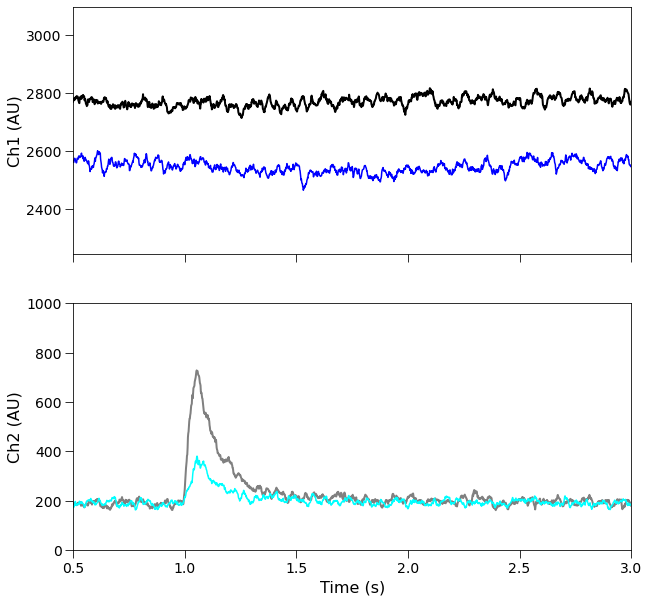

In [340]:
"""Plot red and green channels"""
f, ax = plt.subplots(2, sharex=True, sharey=False, figsize=(10,10))
ax[0].plot(Prdf_avg['Prof 1 Time'], Prdf_avg['Prof 1'], color = 'black', linewidth = 2)
ax[0].plot(Ddf_avg['Prof 1 Time'], Ddf_avg['Prof 1'], color = 'blue')
ax[0].set_ylabel('Ch1 (AU)', fontsize=16)
plt.ylim(0, 3000)
plt.xlim(0.5,3)
ax[1].plot(Prdf_avg['Prof 1 Time'], Prdf_avg['Prof 2'], color = 'grey', linewidth = 2)
ax[1].plot(Ddf_avg['Prof 1 Time'], Ddf_avg['Prof 2'], color = 'cyan')
plt.xlabel('Time (s)', fontsize=16)
ax[1].set_ylabel('Ch2 (AU)', fontsize=16)
plt.ylim(0, 1000)
plt.xlim(0.5,3)

In [341]:
##Sampling interval
TimeInterval = Prdf1['Prof 1 Time'][555] - Prdf1['Prof 1 Time'][554]

##index of timepoints at t = 0.5 s, 0.8s, 0.95s, 1.5s, 2.7s, 2.9s
IndexTimeA = int(0.5/TimeInterval)
IndexTimeB = int(0.8/TimeInterval)
IndexTimeC = int(0.95/TimeInterval)
IndexTimeD = int(1.5/TimeInterval)
IndexTimeE = int(2.7/TimeInterval)
IndexTimeF = int(2.9/TimeInterval)
#print (TimeInterval)
#print(IndexTimeA, IndexTimeB, IndexTimeC, IndexTimeD, IndexTimeE, IndexTimeF)

(0.5, 3.0)

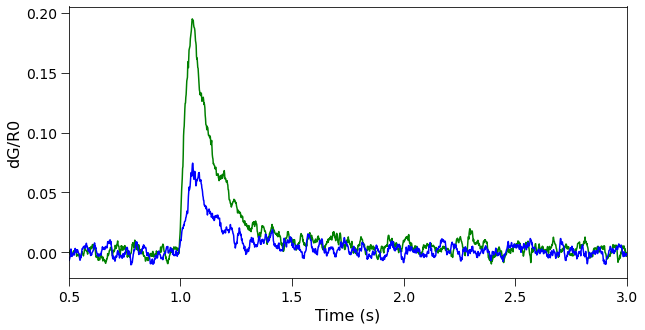

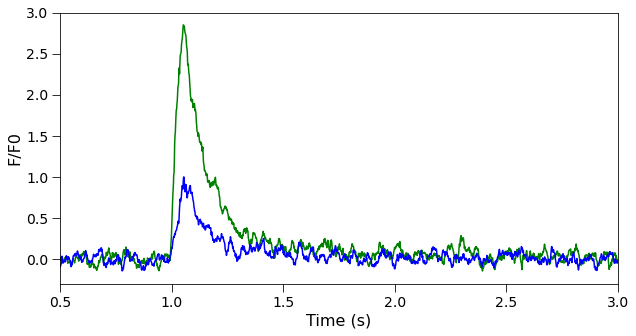

In [342]:
"""calculations for proximal dendrite"""
PFRED = Prdf_avg['Prof 1'][IndexTimeA:IndexTimeC].mean()  ##R0 value from 0.5 to 0.95s
PFGRN = Prdf_avg['Prof 2'][IndexTimeA:IndexTimeC].mean()    ##G0 value from 0.5 to 0.95s
proxGoverR0 = Prdf_avg['Prof 2']/PFRED
proxFoverF0 = Prdf_avg['Prof 2']/PFGRN
proxDeltaGoverR0 = (Prdf_avg['Prof 2']-PFGRN)/PFRED
proxDeltaFoverF0 = proxFoverF0-1
proxAreaG = (proxDeltaGoverR0[IndexTimeC:IndexTimeD].sum()) * TimeInterval
proxAreaF = (proxDeltaFoverF0[IndexTimeC:IndexTimeD].sum()) * TimeInterval

"""Calculations for distal dendrite"""
FRED = Ddf_avg['Prof 1'][IndexTimeA:IndexTimeC].mean()  ##R0 value from 0.5 to 0.95s
FGRN = Ddf_avg['Prof 2'][IndexTimeA:IndexTimeC].mean()    ##G0 value from 0.5 to 0.95s
distGoverR0 = Ddf_avg['Prof 2']/FRED
distFoverF0 = Ddf_avg['Prof 2']/FGRN
distDeltaGoverR0 = (Ddf_avg['Prof 2']-FGRN)/FRED
distDeltaFoverF0 = distFoverF0-1
distAreaG = (distDeltaGoverR0[IndexTimeC:IndexTimeD].sum()) * TimeInterval
distAreaF = (distDeltaFoverF0[IndexTimeC:IndexTimeD].sum()) * TimeInterval

###this basal value should be about 1
BasalRatio = (FGRN/FRED)/(PFGRN/PFRED)

"""To assess dendritic excitablity, distal/proximal should be calculated"""



plt.figure(figsize=(10,5))
plt.plot(Prdf_avg['Prof 2 Time'], proxDeltaGoverR0, color='green')
plt.plot(Ddf_avg['Prof 2 Time'], distDeltaGoverR0, color='blue')
plt.ylabel('dG/R0', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.xlim(0.5,3)
plt.savefig('dG_over_R0.pdf')


plt.figure(figsize=(10,5))
plt.plot(Prdf_avg['Prof 2 Time'], proxDeltaFoverF0, color='green')
plt.plot(Ddf_avg['Prof 2 Time'], distDeltaFoverF0, color='blue')
plt.ylabel('F/F0', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.xlim(0.5,3)


In [343]:
result_values = [BasalRatio, proxAreaF, distAreaF, proxAreaG, distAreaG]
result_names = ['Basal Ratio', 'proximal Area (deltaF/F0)', 'distal Area (deltaF/F0)', 'proximal Area (deltaG/R0)', 'distal Area (deltaG/R0)']
pd.DataFrame(result_values, index = result_names)


,0
Basal Ratio,1.086244
proximal Area (deltaF/F0),0.431088
distal Area (deltaF/F0),0.142927
proximal Area (deltaG/R0),0.029453
distal Area (deltaG/R0),0.010607
